# AutoGluon Text - Multimodal Table with Text

In many applications, text data may be mixed with numeric/categorical data. AutoGluon's `TextPredictor` can train a single neural network that jointly operates on multiple feature types, including text, categorical, and numerical columns. The general idea is to embed the text, categorical and numeric fields separately and fuse these features across modalities. This tutorial demonstrates such an application.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Book Price Prediction Data

For demonstration, we use the book price prediction dataset from the [MachineHack Book Price Prediction Hackathon](https://www.machinehack.com/hackathons/predict_the_price_of_books/overview). Our goal is to predict a book's price given various features like its author, the abstract, the book's rating, etc.

In [2]:
!mkdir -p price_of_books
!wget https://automl-mm-bench.s3.amazonaws.com/machine_hack_competitions/predict_the_price_of_books/Data.zip -O price_of_books/Data.zip
!cd price_of_books && unzip -o Data.zip
!ls price_of_books/Participants_Data

--2021-03-29 05:01:09--  https://automl-mm-bench.s3.amazonaws.com/machine_hack_competitions/predict_the_price_of_books/Data.zip
Resolving automl-mm-bench.s3.amazonaws.com (automl-mm-bench.s3.amazonaws.com)... 52.216.178.139
Connecting to automl-mm-bench.s3.amazonaws.com (automl-mm-bench.s3.amazonaws.com)|52.216.178.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3521673 (3.4M) [application/zip]
Saving to: ‘price_of_books/Data.zip’

price_of_books/Data 100%[===================>]   3.36M  --.-KB/s    in 0.05s   

2021-03-29 05:01:11 (68.6 MB/s) - ‘price_of_books/Data.zip’ saved [3521673/3521673]

Archive:  Data.zip
  inflating: Participants_Data/Data_Test.xlsx  
  inflating: Participants_Data/Data_Train.xlsx  
  inflating: Participants_Data/Sample_Submission.xlsx  
Data_Test.xlsx	Data_Train.xlsx  Sample_Submission.xlsx


In [3]:
train_df = pd.read_excel(os.path.join('price_of_books', 'Participants_Data', 'Data_Train.xlsx'), engine='openpyxl')
train_df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


We do some basic preprocessing to convert `Reviews` and `Ratings` in the data table to numeric values, and we transform prices to a log-scale.

In [4]:
def preprocess(df):
    df = df.copy(deep=True)
    df.loc[:, 'Reviews'] = pd.to_numeric(df['Reviews'].apply(lambda ele: ele[:-len(' out of 5 stars')]))
    df.loc[:, 'Ratings'] = pd.to_numeric(df['Ratings'].apply(lambda ele: ele.replace(',', '')[:-len(' customer reviews')]))
    df.loc[:, 'Price'] = np.log(df['Price'] + 1)
    return df


train_subsample_size = 1500  # subsample for faster demo, you can try setting to larger values
test_subsample_size = 5
train_df = preprocess(train_df)
train_data = train_df.iloc[100:].sample(train_subsample_size, random_state=123)
test_data = train_df.iloc[:100].sample(test_subsample_size, random_state=245)
train_data.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
949,Furious Hours,Casey Cep,"Paperback,– 1 Jun 2019",4.0,NaN,‘It’s been a long time since I picked up a boo...,True Accounts (Books),"Biographies, Diaries & True Accounts",5.743003
5504,REST API Design Rulebook,Mark Masse,"Paperback,– 7 Nov 2011",5.0,NaN,"In todays market, where rival web services com...","Computing, Internet & Digital Media (Books)","Computing, Internet & Digital Media",5.786897
5856,The Atlantropa Articles: A Novel,Cody Franklin,"Paperback,– Import, 1 Nov 2018",4.5,2.0,#1 Amazon Best Seller! Dystopian Alternate His...,Action & Adventure (Books),Romance,6.893656
4137,Hickory Dickory Dock (Poirot),Agatha Christie,"Paperback,– 5 Oct 2017",4.3,21.0,There’s more than petty theft going on in a Lo...,Action & Adventure (Books),"Crime, Thriller & Mystery",5.192957
3205,The Stanley Kubrick Archives (Bibliotheca Univ...,Alison Castle,"Hardcover,– 21 Aug 2016",4.6,3.0,"In 1968, when Stanley Kubrick was asked to com...",Cinema & Broadcast (Books),Humour,6.889591


## Training

We can simply create a TextPredictor and call `predictor.fit()` to train a model that operates on across all types of features. Internally, the neural network will be automatically generated based on the inferred data type of each feature column. To save time, we subsample the data and only train for three minutes.

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
INFO:autogluon.text.text_prediction.mx.models:The GluonNLP V0 backend is used. We will use 8 cpus and 1 gpus to train each trial.


All Logs will be saved to /home/ec2-user/SageMaker/ag_text_book_price_prediction/task0/training.log


INFO:root:Fitting and transforming the train data...
INFO:root:Done! Preprocessor saved to /home/ec2-user/SageMaker/ag_text_book_price_prediction/task0/preprocessor.pkl
INFO:root:Process dev set...
INFO:root:Done!
INFO:root:Max length for chunking text: 480, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
INFO:root:#Total Params/Fixed Params=109338913/0
Level 15:root:Using gradient accumulation. Global batch size = 128
INFO:root:Local training results will be saved to /home/ec2-user/SageMaker/ag_text_book_price_prediction/task0/results_local.jsonl.
Level 15:root:[Iter 1/100, Epoch 0] train loss=2.59e+00, gnorm=6.77e+01, lr=1.00e-05, #samples processed=128, #sample per second=23.72. ETA=8.90min
Level 15:root:[Iter 2/100, Epoch 0] train loss=1.96e+00, gnorm=3.61e+01, lr=2.00e-05, #samples processed=128, #sample per second=25.94. ETA=8.44min
Level 25:root:[Iter 2/100, Epoch 0] valid r2=-8.5137e-01, root_mean_squared_error=1.0945e+00, mean_absolute_error=9.1826e-01, time spent=3

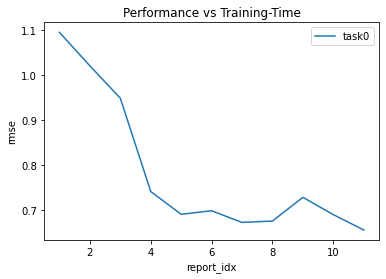

INFO:root:Training completed. Auto-saving to "ag_text_book_price_prediction/". For loading the model, you can use `predictor = TextPredictor.load("ag_text_book_price_prediction/")`


In [5]:
from autogluon.text import TextPredictor
time_limit = 3 * 60  # set to larger value in your applications
predictor = TextPredictor(label='Price', path='ag_text_book_price_prediction')
predictor.fit(train_data, time_limit=time_limit)

## Prediction

We can easily obtain predictions and extract data embeddings using the TextPredictor.

In [6]:
predictions = predictor.predict(test_data)
print('Predictions:')
print('------------')
print(np.exp(predictions) - 1)
print()
print('True Value:')
print('------------')
print(np.exp(test_data['Price']) - 1)

Predictions:
------------
1     379.644348
31    501.940033
19    777.077087
45    696.023254
82    719.594971
Name: Price, dtype: float32

True Value:
------------
1     202.93
31    799.00
19    352.00
45    395.10
82    409.00
Name: Price, dtype: float64


In [7]:
performance = predictor.evaluate(test_data)
print(performance)

0.6110616326332092


In [8]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

[[ 0.03847877  0.61906475 -0.5000607  ...  0.16537136 -0.02312354
  -0.01483897]
 [ 0.1159624   0.6617308  -0.35742673 ...  0.05477808  0.02060554
  -0.03079564]
 [ 0.08874278  0.6831325  -0.40776396 ... -0.45953295  0.40670896
   0.23620553]
 [ 0.06456596  0.6556821  -0.41806728 ... -0.0819485   0.08949058
   0.4200689 ]
 [ 0.0751583   0.6933143  -0.55531085 ...  0.04326446 -0.02155675
   0.29913387]]


## What's happening inside?

Internally, we use different networks to encode the text columns, categorical columns, and numerical columns. The features generated by individual networks are aggregated by a late-fusion aggregator. The aggregator can output both the logits or score predictions. The architecture can be illustrated as follows:

![Multimodal Network with Late Fusion](https://autogluon-text-data.s3.amazonaws.com/figures/fuse-late.png)

Here, we use the pretrained NLP backbone to extract the text features and then use two other towers to extract the feature from categorical column and the numerical column.

In addition, to deal with multiple text fields, we separate these fields with the `[SEP]` token and alternate 0s and 1s as the segment IDs, which is shown as follows:

![Preprocessing](https://autogluon-text-data.s3.amazonaws.com/figures/preprocess.png)

## How does this compare with TabularPredictor?

Note that `TabularPredictor` can also handle data tables with text, numeric, and categorical columns, but it uses an ensemble of many types of models and may featurize text. `TextPredictor` instead directly fits individual Transformer neural network models directly to the raw text (which are also capable of handling additional numeric/categorical columns). We generally recommend TabularPredictor if your table contains mainly numeric/categorical columns and TextPredictor if your table contains mainly text columns, but you may easily try both and we encourage this. In fact, `TabularPredictor.fit(..., hyperparameters='multimodal')` will train a TextPredictor along with many tabular models and ensemble them together. Refer to our next tutorial for more details.

## Other Examples

You may go to https://github.com/awslabs/autogluon/tree/master/examples/text_prediction to explore other TextPredictor examples, including scripts to train a TextPredictor on the complete book price prediction dataset.